### 讀入資料

In [2]:
import torchvision
from torchvision import transforms, utils
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

train_image_folder = torchvision.datasets.ImageFolder("HW1-image/reference", transform=transforms.Compose([
                                                transforms.RandomResizedCrop(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor()]))
print(train_image_folder.class_to_idx)

{'cats': 0, 'dogs': 1, 'processing': 2}


In [3]:
loader = transforms.Compose([
    transforms.ToTensor()]) 

In [4]:
x_test = []
for i in range(1,21):
    img = Image.open("HW1-image/test/pic"+ str(i) + ".jpg")
    img = img.resize((224,224))
    img_tensor = loader(img).unsqueeze(0) # tensor數據格式是torch(C,H,W)
    x_test.append(img_tensor)
    
y_test = [0,1,0,1,0,0,1,1,1,0,0,1,0,1,1,0,1,1,0,0]
print(len(y_test))

20


0 torch.Size([50, 3, 224, 224]) torch.Size([50])


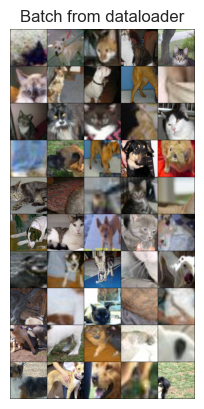

1 torch.Size([50, 3, 224, 224]) torch.Size([50])


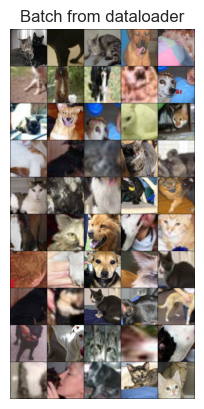

2 torch.Size([50, 3, 224, 224]) torch.Size([50])


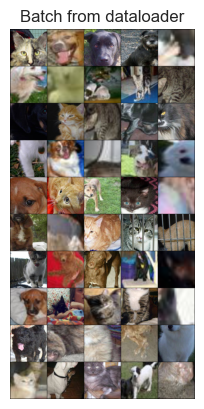

3 torch.Size([50, 3, 224, 224]) torch.Size([50])


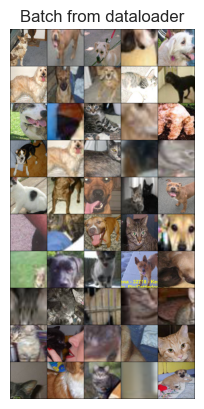

In [5]:
def show_batch(imgs):
    grid = utils.make_grid(imgs,nrow=5)  # 設定一排幾張
    plt.imshow(grid.numpy().transpose((1, 2, 0)))  # 轉換成imshow格式
    plt.title('Batch from dataloader')
arr=[]
train_data_loader = torch.utils.data.DataLoader(train_image_folder, batch_size=50,shuffle=True)

for i, (batch_x, batch_y) in enumerate(train_data_loader):
    if(i<4):  # 限制次數
        print(i, batch_x.size(), batch_y.size())
        arr = np.append(arr, batch_y.numpy(), axis=0)
        
        show_batch(batch_x)
        plt.axis('off')
        plt.show()

### 搭建神經網路

In [6]:
#搭建神經網路
from torch import nn
class my_CNN(nn.Module):
    def __init__(self):
        super(my_CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 2), # 3 @ 224*224 -> 32 @ 224*224
            nn.MaxPool2d(2),           # -> 32 @ 112*112
            nn.Conv2d(32, 32, 5, 1, 2),# -> 32 @ 112*112
            nn.MaxPool2d(2),           # -> 32 @ 56*56
            nn.Conv2d(32, 64, 5, 1, 2),# -> 64 @ 56*56
            nn.MaxPool2d(2),           # -> 64 @ 28*28
            nn.Flatten(),               
            nn.Linear(64*28*28, 2),    
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.model(x)
        return x

### 訓練模型

In [7]:
my_model = my_CNN()
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-2
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate)

# 紀錄訓練的次數
total_train_step = 0
# 紀錄測試的次數
total_test_step = 0
# 訓練輪數
epoch = 1

#預測集
pred_arr = []
for i in range(epoch):
    print(f"\n--------------第{i+1:2} 輪訓練--------------")
 #訓練步驟開始
    for data in train_data_loader:
        imgs, targets = data              #擷取資料
        print()
        pred = my_model(imgs)             #預測
        loss = loss_fn(pred, targets)     #計算誤差

        # 優化器優化模型
        optimizer.zero_grad()             #把梯度清零
        loss.backward()                   #計算損失的梯度
        optimizer.step()                  #優化

        total_train_step += 1
        print(f"訓練次數:{total_train_step}, loss:{loss.item()}")
    
    with torch.no_grad():
        for data in train_data_loader:
            imgs, targets = data
            pred = my_model(imgs)
            for k in pred:
                pred_arr = np.append(pred_arr, 0 if k[0] > k[1] else 1)
                print(k[0], k[1])


--------------第 1 輪訓練--------------


IndexError: Target 2 is out of bounds.

### 訓練結果請輸出混肴矩陣(confusion matrix)，並計算 AUROC 的數值。

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
print(pred_arr)
print()
print(arr)

report = classification_report(arr,pred_arr)
print(report)

### 儲存訓練模型

In [ ]:
# 顯示目前模型資料
model_state = my_model.state_dict()
# print(model_state)

torch.save(model_state, "HW4/HW4.h5")

### 載入模型

In [ ]:
load_model = my_CNN() # 必須先創建模型
load_model.load_state_dict(torch.load("HW4/HW4.h5"))
load_state = load_model.state_dict()

# print(load_state)
load_model.eval() # 進入評估狀態 

In [ ]:
loader = transforms.Compose([
    transforms.ToTensor()]) 

### 預測Test資料

In [ ]:
acc = 0
for i in range(0,len(x_test)):
    pred = load_model(x_test[i])
    print(pred)
    class_type = 0 if pred[0][0] > pred[0][1] else 1
    img = Image.open("HW1-image/test/pic"+ str(i+1) + ".jpg")
    img = img.resize((128,128))
    display(img)
    print("Cat" if pred[0][0] > pred[0][1] else "Dog")
    if(class_type == y_test[i]):
        acc+=1
print("準確度：", acc/len(x_test))